In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_csv('data/demographic.csv')
df2 = pd.read_csv('data/questionnaire.csv')

df = pd.concat([df1, df2], axis=1, join='inner')

df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


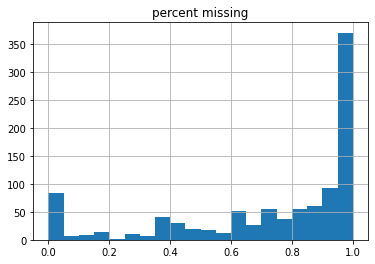

In [3]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent missing'])
pos = nas['percent missing'] > 0
nas[pos]
nas.hist(bins = 20)
acceptable_feats = nas.loc[nas['percent missing'] < 0.2]
list_acceptable_feats = list(acceptable_feats.index)

In [4]:
print('Shape of DataFrame with all data: ', df.shape)
df = df.loc[(df.RIDAGEYR >= 20)]
#df2 = df1#[df1.columns[df1.isna().sum() < 1000]]
print('Shape of DataFrame with only 20 year olds and older: ', df.shape)

Shape of DataFrame with all data:  (10175, 1000)
Shape of DataFrame with only 20 year olds and older:  (5769, 1000)


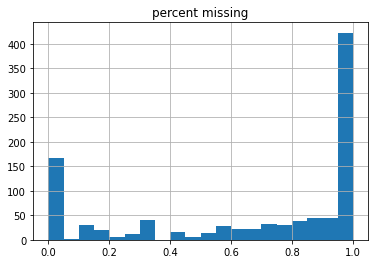

In [5]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent missing'])
pos = nas['percent missing'] > 0
nas[pos]
nas.hist(bins = 20)
acceptable_feats = nas.loc[nas['percent missing'] < 0.2]
list_acceptable_feats = list(acceptable_feats.index)

In [6]:
c = df[list_acceptable_feats].corr().abs()
dc = c['DIQ010'].dropna().sort_values(kind="quicksort", ascending=False)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
print(dc)

DIQ010      1.000000
DIQ160      0.366512
DIQ050      0.339186
MCQ365D     0.178347
RIDAGEYR    0.172404
              ...   
OHQ835      0.001132
FSDHH       0.000851
MIAINTRP    0.000617
CBQ535      0.000106
OHQ770      0.000021
Name: DIQ010, Length: 215, dtype: float64


In [7]:
df = df[list_acceptable_feats]
df = df[df['DIQ010'].notna()]
df = df[df['DIQ010'] != 3]
print("Percentage of survey responders with diabetes: ", df[df['DIQ010'] == 1].shape[0]/df.shape[0])

Percentage of survey responders with diabetes:  0.1290437890974084


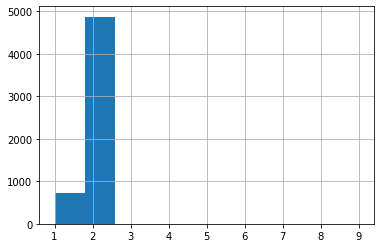

In [8]:
df['DIQ010'].hist()

In [9]:
# #feature creation for has smoked and drank
# new_col = []
# for row_num in range(df3.shape[0]):
#     if df3.iloc[row_num]['ALQ101'] == 1 and df3.iloc[row_num]['SMQ020'] == 1:
#         new_col.append(1)
#     else:
#         new_col.append(0)
# smoke_drink = pd.Series(new_col)
# if 'smoke_drink' not in df3.columns:
#     df3.insert(0, "smoke_drink", smoke_drink)
# df3.head()

# #feature creation for takeout/groceries
# new_col = []
# for row_num in range(df3.shape[0]):
#     if (df3.iloc[row_num]['CBD070'] != (999999) and df3.iloc[row_num]['CBD070'] != (777777)) and (df3.iloc[row_num]['CBD130'] != (999999) and df3.iloc[row_num]['CBD130'] != (777777)):
#         new_col.append(df3.iloc[row_num]['CBD130']/(df3.iloc[row_num]['CBD070']+0.01))
#     else:
#         new_col.append(np.nan)
# takeout_groceries = pd.Series(new_col)
# if 'takeout_groceries' not in df3.columns:
#     df3.insert(0, "takeout_groceries", takeout_groceries)
# df3.head()
# df3['takeout_groceries'].max()

In [10]:
from sklearn.impute import KNNImputer
import time

tic = time.time()

col_names = list(df.columns)

print('Before imputation: ', df.isnull().sum().sum(), 'missing')

#fill na's with medians
for col in df.columns:
    df[col] = df[col].fillna((df[col].median()))
    
#fill na's using KNN
#imputer = KNNImputer(n_neighbors=3)
#df = pd.DataFrame(imputer.fit_transform(df))
      
print('After imputation: ', df.isnull().sum().sum(), 'missing')

df.columns = col_names

toc = time.time()
print('runtime: ',toc-tic)

Before imputation:  43817 missing
After imputation:  0 missing
runtime:  0.5237078666687012


In [11]:
print('Shape of DataFrame before dropping unwanted features: ', df.shape)
remove_list = ['DIQ160', 'DIQ050', 'DIQ180', 'DIQ172', 'DIQ170']#, 'SLQ060', 'SIAPROXY', 'HUQ010', 'HUQ010', 'DMDHRAGE', 'DLQ060', 'RIDAGEYR', 'DLQ050', 'WTINT2YR', 'WTMEC2YR']
keep_list = set(df.columns) - set(remove_list)
df = df[keep_list]
prefix_list = []#['MCQ','HUQ','BPQ','PFQ','DLQ','HSD', 'OHQ', 'WHQ', 'SEQN', 'DPQ', 'HIQ', 'HSQ', 'WHD', 'DMD', 'DBQ']
df = df.loc[:,~df.columns.str.startswith(tuple(prefix_list))]
print('Shape of DataFrame after dropping unwanted features: ', df.shape)

c1 = df.corr().abs()
dc1 = c1['DIQ010'].dropna().sort_values(kind="quicksort", ascending=False)

df = df[list(dc1.index)[:6]]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dc1[:6])

Shape of DataFrame before dropping unwanted features:  (5595, 221)
Shape of DataFrame after dropping unwanted features:  (5595, 216)
DIQ010      1.000000
MCQ365D     0.249648
RIDAGEYR    0.243945
MCQ365A     0.239043
MCQ365B     0.230617
MCQ365C     0.220439
Name: DIQ010, dtype: float64


In [12]:
from sklearn import preprocessing

X = df.drop('DIQ010', 1)
y = df['DIQ010']

#Dummy variables
dummy_list = []
for col in df.drop('DIQ010', 1).columns:
    if df[col].max() <= 99:
        dummy_list.append(col)
X = pd.get_dummies(X, prefix=dummy_list, columns=dummy_list)

# Here we use the StandardScaler() method of the preprocessing package, and then call the fit() method with parameter X 
scaler = preprocessing.StandardScaler().fit(X)

# Declare a variable called X_scaled, and assign it the result of calling the transform() method with parameter X 
X_scaled=scaler.transform(X)

# Get the 1-dimensional flattened array of our response variable y by calling the ravel() function on y
y = y.ravel()

In [13]:
from sklearn.model_selection import train_test_split

# Call the train_test_split() function with the first two parameters set to X_scaled and y 
# Declare four variables, X_train, X_test, y_train and y_test separated by commas 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.99, random_state=1)

In [14]:
import time
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

tic = time.time()

# Initialize our classifier
clf = RandomForestClassifier(max_depth=100, n_estimators=60, max_features=60)

# Train our classifier
model = clf.fit(X_train, y_train)

# Make predictions
preds = clf.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

toc = time.time()
print('runtime: ',toc-tic)

[2. 2. 1. ... 2. 2. 2.]
0.8299638989169675
runtime:  0.14403986930847168


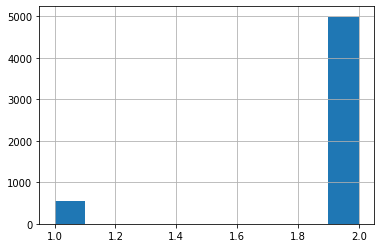

In [15]:
pd.Series(preds).hist()

In [16]:
results = pd.DataFrame(y_test)
results.columns = ['y_test']
results['preds'] = preds
results.head()

,y_test,preds
0,1.0,2.0
1,2.0,2.0
2,1.0,1.0
3,2.0,2.0
4,2.0,2.0


In [17]:
true_pos = 0
true_neg = 0

for i in range(results.shape[0]):
    if results.iloc[i][0] == 1 and results.iloc[i][1] == 1:
        true_pos += 1
    elif results.iloc[i][0] == 2 and results.iloc[i][1] == 2:
        true_neg += 1

print('Sensitivity: ', true_pos/results[results.y_test ==  1].shape[0])
print('Specificity: ', true_neg/results[results.y_test ==  2].shape[0])

Sensitivity:  0.22849083215796898
Specificity:  0.9188069594034797
